In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.transforms as mtransforms


from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)


Using TensorFlow backend.


In [2]:
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2


In [4]:
# load  dataset
df = pd.read_csv('/home/francovm/Projects/SSE/data/processed/GISB.csv', sep='\t', encoding='utf-8')


[]

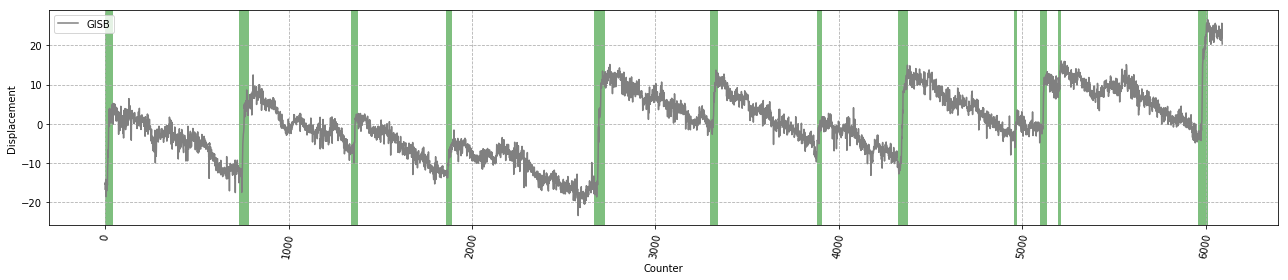

In [9]:
fig, ax = plt.subplots()

plt.plot(df['x'],'-', color='gray',label="GISB")
# plt.plot(dataset_test['Events'],'-', color='gray',label="GISB")
    # plt.plot_date(visitors2['Date'],visitors2['Visitors'].rolling(5).mean(),'g-',label="Unique Visitors- mean")

    # plt.axvline(x='2018-07-31', color='r', linestyle='--',label="CWB turn off")
plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
# if (dataset_test['Events'] == 0.5): plt.axhline()
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df['Events'])), min(df['Events']), max(df['Events']), where=(df['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

In [10]:
input_X = df.loc[:, df.columns != 'Events'].values  # converts the df to a numpy array
input_y = df['Events'].values

n_features = input_X.shape[1]  # number of features

print(input_X.shape,input_y.shape)

(6091, 6) (6091,)


In [20]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return np.array(X), np.array(y)

In [23]:
# Temporalize the data
lookback = 20
X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [24]:
print(X_gisb.shape,y_gisb.shape)

(6070, 20, 6) (6070,)


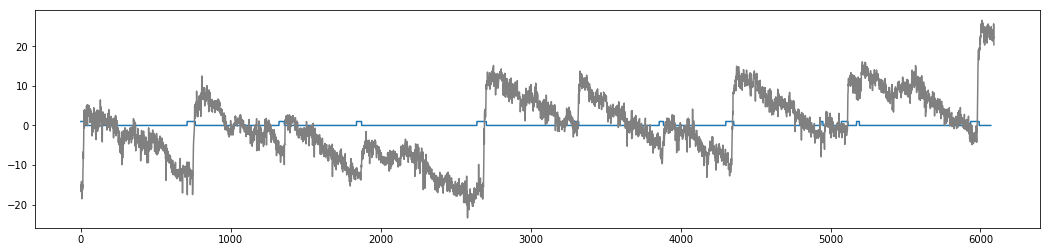

In [29]:
plt.plot(y_gisb) # plotting by columns
plt.plot(df['x'],'-', color='gray',label="GISB")
# plt.axhline(0.5)
plt.show()

In [ ]:
y_pred = model.predict_classes(test_X)

In [ ]:
plt.plot(y_pred) # plotting by columns
plt.plot(df['x'],'-', color='gray',label="GISB")
# plt.axhline(0.5)
plt.show()